## Задача:
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.


In [1]:
from scipy.stats import ttest_1samp, ttest_ind, mannwhitneyu, shapiro, pearsonr

from statsmodels.stats import proportion
from statsmodels.stats.power import TTestIndPower

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
df = pd.read_excel('AB_Test_Results.xlsx')

In [5]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


### Основные показатели

In [7]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


### Количество пользователей в группах

In [8]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

### Проверим есть ли пользователи попавшие в обе группы

In [10]:
variants = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})

In [11]:
variants.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


По результатам видно, что есть пользователи, которые учитываются и в одной группе и в другой. Их необходимо усключить из дальнейшего исследования.

In [12]:
more_than_one_types = variants.query('VARIANT_NAME > 1')

In [13]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [14]:
df_new.shape, df.shape

((6070, 3), (10000, 3))

Удаляем дубли и сохраняем группы в разные переменные

In [15]:
control = df_new.query('VARIANT_NAME == "control"')
len(control)

3026

In [16]:
test = df_new.query('VARIANT_NAME == "variant"')
len(test)

3044

In [17]:
(5016-3044)/5016

0.39314194577352474

In [18]:
(4984-3026)/4984

0.39285714285714285

Как видно по результатам исключения дублей, пользователй, которые попали в обе группы очень много, по 39 % в каждой группе. Встает вопрос о качестве сплитования.

### Проверим данные на нормальность распеределия с помощью теста Шапиро-Уилка

In [21]:
alpha = 0.05

st = shapiro(df.REVENUE)

st[1] < alpha

True

Распределение отличается от нормального.

### Построим графики распределений

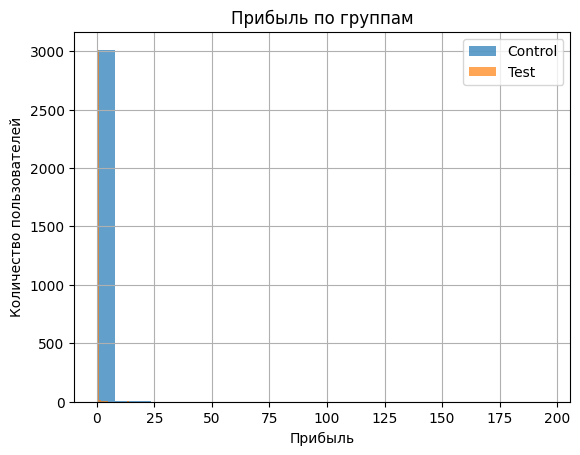

In [22]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Прибыль по группам')
plt.xlabel('Прибыль')
plt.ylabel('Количество пользователей')
plt.legend();

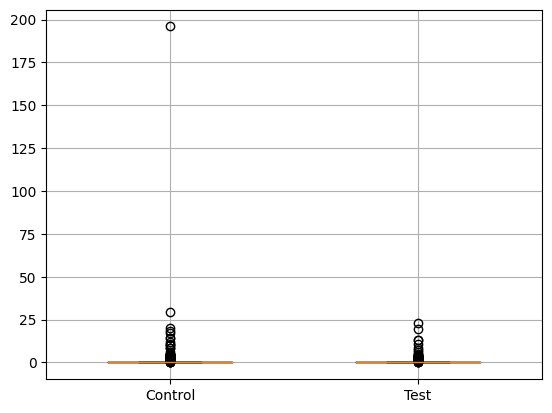

In [23]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Control','Test'],
            widths=0.5
           )
plt.grid(axis='both')

### Поскольку данные распределены не нормально, то для определения наличия статистичиски значимых отличий воспользуемся критерием Манна-Уитни.

In [24]:
mw_stats = mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

Поскольку pvalue больше 5 %, то статистически значимых различий нет.

### Посчитаем мощность теста

In [25]:
ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

In [26]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()
C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

In [27]:
n =  len(control.REVENUE.values)

In [28]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [29]:
effect = float((T_mean-C_mean)/ S) 

In [30]:
alpha = 0.05

analysis = TTestIndPower()

result = analysis.solve_power(effect, power=None,nobs1=n, ratio=1.0, alpha=alpha)
result

0.2893670730459212

### Мощность теста очень низкая

## Анализ результатов эксперимента выявил следующее:

1.   Очень низкое качество сплитования пользователей. 39% пользователей попали в обе группы. Необходимо провести А/А тестирование для контроля работы алгоритма сплитования и внести необходимые изменения в его работу.
2.   Мощность теста очень низкая. Необходимо продолжить эксперимент, а если он уже закончен, то провести его вновь с увеличенным сроком для выхода на требуемую мощность для достоверного определения влияния гипотезы на доход, принесенный пользователем.
3.   На текущем этапе внесение изменений на сайт не требуется.

